<a href="https://colab.research.google.com/github/portmajm/JuliaTraining/blob/main/03_ypm_insect_downloading_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook overview
This notebook loads in entomology data from YPM via pygbif, cleans the dataset, and summarizes it into a dataset with insect richness (number of species) and abundance (number of occurrences) by state and year, broken down by assorted taxonomies.

# Dataset description
A detailed description can be found [here](https://www.gbif.org/dataset/96404cc2-f762-11e1-a439-00145eb45e9a), but in short, this dataset comprises all insect specimens collected by researchers affiliated with the Yale Peabody Museum or specimens donated to the museum collections. The majority of specimens are Lepidoptera (butterflies) and other terrestrial insects. A small subset are aquatic insects. The dataset includes specimens from all continents except Antarctica and the earliest specimen was collected in 1656, although most records are from after 1900.

Dataset citation: GBIF.org (02 April 2025) GBIF Occurrence Download  https://doi.org/10.15468/dl.y6dcyx

# Dataset loading and cleaning
Install pygbif and load in modules

## Load modules

In [1]:
# need to install pygbif module
!pip install pygbif

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.2/70.2 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 4.6 MB/s eta 0:00:00


In [2]:
# import modules
import pandas as pd
import numpy as np

from pygbif import occurrences as occ # I think we only need the occurrences module

from google.colab import userdata # for accessing username and password stored in environment variables

# Plotting
from plotnine import *
import plotnine
from mizani.formatters import scientific_format, percent_format, currency_format

# Stats
import statsmodels.api as sm
import scipy.stats as stats


## Download YPM ENT data
Using pygbif and the known institution and collection codes, we can download all insect data collected by the Peabody using my (Julia's) personal GBIF account credentials to download the most up to date dataset.

Note that we could further refine the download to certain geographic areas or taxa, but for now want the full dataset.

In [ ]:
# download ypm ent data
ent = occ.download(['institutionCode = YPM', 'collectionCode = ENT'], pred_type ='and',
                      user=userdata.get('GBIF_USER'), pwd=userdata.get('GBIF_PWD'), email='portmajm@gmail.com') # i think these should be able to be read in without stating?

In [ ]:
ent # will send an email when the download is ready

('0000426-250402121839773',
 {'creator': 'portmajm',
  'notification_address': ['portmajm@gmail.com'],
  'sendNotification': True,
  'predicate': {'type': 'and',
   'predicates': [{'type': 'equals',
     'key': 'INSTITUTION_CODE',
     'value': 'YPM'},
    {'type': 'equals', 'key': 'COLLECTION_CODE', 'value': 'ENT'}]},
  'format': 'SIMPLE_CSV'})

I have not confirmed, but I think that if you have the pygbif module downloaded, anyone can get the dataset with the following code. The raw dataset is too big to load to GitHub but I can share it elsewhere if needed.

In [ ]:
# use the key at top of previous chunk for downloading file
# this key will stay the same, so can start at this step in the future
occ.download_get(key='0000426-250402121839773')

{'path': './0000426-250402121839773.zip',
 'size': 70743130,
 'key': '0000426-250402121839773'}

In [ ]:
!ls

0000426-250402121839773.zip  sample_data


In [ ]:
!unzip 0000426-250402121839773.zip

Archive:  0000426-250402121839773.zip
  inflating: 0000426-250402121839773.csv  


In [ ]:
!ls

0000426-250402121839773.csv  0000426-250402121839773.zip  sample_data


In [ ]:
# read in dataset
df_ent = pd.read_csv('0000426-250402121839773.csv', index_col = False,sep="\t")

<ipython-input-6-4a0bf1807e53>:2: DtypeWarning: Columns (39) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ent = pd.read_csv('0000426-250402121839773.csv', index_col = False,sep="\t")


## Explore dataset, identify cleaning needs

In [ ]:
df_ent.head()

,gbifID,datasetKey,occurrenceID,kingdom,phylum,class,order,family,genus,species,...,identifiedBy,dateIdentified,license,rightsHolder,recordedBy,typeStatus,establishmentMeans,lastInterpreted,mediaType,issue
0,3913895301,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:00006775-753e-4ed0-bbe6-0702cae6c26b,Animalia,Arthropoda,Insecta,Lepidoptera,Papilionidae,Papilio,Papilio polyxenes,...,NaN,NaN,CC0_1_0,Yale Peabody Museum,R. T. Cail,NaN,NaN,2025-04-01T13:31:34.353Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
1,1438048515,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:000426c2-4fff-44bf-97c3-461d8022c177,Animalia,Arthropoda,Insecta,Lepidoptera,Noctuidae,Achatia,Achatia evicta,...,NaN,NaN,CC0_1_0,Yale Peabody Museum,Richard E. Gray,NaN,NaN,2025-04-01T13:31:34.410Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
2,1838432720,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:00091984-cf96-4498-a6c6-e034f72a355a,Animalia,Arthropoda,Insecta,Lepidoptera,Geometridae,Lobophora,Lobophora nivigerata,...,NaN,NaN,CC0_1_0,Yale Peabody Museum,David S. MacDonald,NaN,NaN,2025-04-01T13:31:25.822Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
3,1935872503,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:0009a4ea-0d53-46da-bf70-949145977b1b,Animalia,Arthropoda,Insecta,Lepidoptera,Geometridae,Metarranthis,Metarranthis amyrisaria,...,NaN,NaN,CC0_1_0,Yale Peabody Museum,"Timothy L. McCabe, Dale F. Schweitzer",NaN,NaN,2025-04-01T13:31:34.328Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
4,2565549387,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:000a73bd-10b3-46d3-b38c-be8c3d909b83,Animalia,Arthropoda,Insecta,Lepidoptera,Crambidae,Parapoynx,Parapoynx obscuralis,...,NaN,NaN,CC0_1_0,Yale Peabody Museum,Herman P. Wilhelm,NaN,NaN,2025-04-01T13:31:34.426Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...


In [ ]:
df_ent.info()

# note that coordinatePrecision, depth, depthAccuracy, establishmentMeans are all null, recordNumber, typeStatus are mostly null

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421950 entries, 0 to 421949
Data columns (total 50 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   gbifID                            421950 non-null  int64  
 1   datasetKey                        421950 non-null  object 
 2   occurrenceID                      421950 non-null  object 
 3   kingdom                           421950 non-null  object 
 4   phylum                            421438 non-null  object 
 5   class                             421424 non-null  object 
 6   order                             421394 non-null  object 
 7   family                            420948 non-null  object 
 8   genus                             415811 non-null  object 
 9   species                           392092 non-null  object 
 10  infraspecificEpithet              3666 non-null    object 
 11  taxonRank                         421950 non-null  o

In [ ]:
df_ent.value_counts('order').head(10)
# butterflies/moths, bees/wasps, flies, beetles, dragonflies/damselflies are the top 5 most recorded insect orders
# this is not surprising, given that these tend to be the most 'charismatic' of insects

,count
order,
Lepidoptera,349114
Hymenoptera,22832
Diptera,19248
Coleoptera,15547
Odonata,6428
Hemiptera,3655
Ixodida,1056
Trichoptera,773
Neuroptera,601


In [ ]:
df_ent[df_ent.stateProvince == 'Connecticut'].value_counts('order').head(10)
# pretty much mirrors the overall dataset

,count
order,
Lepidoptera,51071
Hymenoptera,4437
Diptera,3486
Coleoptera,2891
Odonata,1020
Trichoptera,712
Neuroptera,508
Hemiptera,478
Megaloptera,221


In [ ]:
df_ent.value_counts('family').head(10)

,count
family,
Noctuidae,59120
Erebidae,57480
Nymphalidae,52609
Geometridae,38142
Papilionidae,23918
Hesperiidae,23334
Pieridae,19696
Lycaenidae,19529
Apidae,17807


## Check that all records are actually insects

### Check kingdoms

In [ ]:
# check unique kingdoms - should all be Animalia
df_ent.kingdom.unique()
# not all Animalia, uh oh!

array(['Animalia', 'Chromista', 'Plantae', 'Protozoa', 'incertae sedis'],
      dtype=object)

In [ ]:
# check rows that are not animalia - are they incorrectly labelled or mistakenly included?
df_ent[df_ent.kingdom != 'Animalia']
# 78 non-Animalia records

,gbifID,datasetKey,occurrenceID,kingdom,phylum,class,order,family,genus,species,...,identifiedBy,dateIdentified,license,rightsHolder,recordedBy,typeStatus,establishmentMeans,lastInterpreted,mediaType,issue
821,3045462302,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:040df1fd-b07f-4f0b-be10-e83d77c4d46a,Chromista,Myzozoa,Aconoidasida,Haemospororida,Plasmodiidae,Plasmodium,NaN,...,NaN,NaN,CC0_1_0,Yale Peabody Museum,NaN,NaN,NaN,2025-04-01T13:31:36.022Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
3363,3045462304,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:10308dcf-fe54-4ff1-b0db-6612ca54f297,Chromista,Myzozoa,Aconoidasida,Haemospororida,Plasmodiidae,Plasmodium,NaN,...,NaN,NaN,CC0_1_0,Yale Peabody Museum,NaN,NaN,NaN,2025-04-01T13:31:39.878Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
5626,4007533327,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:1b6f8af9-531a-4825-b5a5-b6f946fd653d,Plantae,Tracheophyta,Liliopsida,Poales,Poaceae,Zea,NaN,...,NaN,NaN,CC0_1_0,Yale Peabody Museum,R. Godefroi,NaN,NaN,2025-04-01T13:31:42.697Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
6663,3045462307,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:2063826e-f1b3-4a41-a745-49729f9ec1bf,Chromista,Myzozoa,Aconoidasida,Haemospororida,Plasmodiidae,Plasmodium,NaN,...,NaN,NaN,CC0_1_0,Yale Peabody Museum,NaN,NaN,NaN,2025-04-01T13:31:43.782Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
21328,3045472317,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:675ebd39-0b6c-4829-b311-1d10db619f7a,Protozoa,Euglenozoa,Kinetoplastea,Trypanosomatida,Trypanosomatidae,Trypanosoma,NaN,...,NaN,NaN,CC0_1_0,Yale Peabody Museum,NaN,NaN,NaN,2025-04-01T13:31:56.927Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398178,1658217258,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:8c7573aa-e483-4e0a-85a0-4d6779409b15,incertae sedis,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,CC0_1_0,Yale Peabody Museum,Lionel P. Grey,NaN,NaN,2025-04-01T13:31:53.043Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
399219,1039128077,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:9188c741-7118-4f84-8b95-a101e480118e,incertae sedis,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,CC0_1_0,Yale Peabody Museum,"Lawrence F. Gall, Raymond J. Pupedis, Nicole M...",NaN,NaN,2025-04-01T13:31:53.493Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
404490,3045474324,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:ab4695de-8e26-4684-83e5-030ba42ed147,Chromista,Myzozoa,Aconoidasida,Haemospororida,Plasmodiidae,Plasmodium,NaN,...,NaN,NaN,CC0_1_0,Yale Peabody Museum,NaN,NaN,NaN,2025-04-01T13:32:06.458Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
406539,4007535485,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:b58906ab-2ff6-4f11-a47c-64c9185686b3,Plantae,Tracheophyta,Liliopsida,Poales,Poaceae,Zea,NaN,...,NaN,NaN,CC0_1_0,Yale Peabody Museum,R. Godefroi,NaN,NaN,2025-04-01T13:32:07.703Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...


In [ ]:
# which genera are present?
df_ent[df_ent.kingdom != 'Animalia'].genus.unique()
# Zea are grasses, Plasmodium and Trypanosoma are protozoa

array(['Plasmodium', 'Zea', 'Trypanosoma', nan], dtype=object)

In [ ]:
# check families, trying to find the records that are nan genera
df_ent[df_ent.kingdom != 'Animalia'].family.unique()
# same taxa present

array(['Plasmodiidae', 'Poaceae', 'Trypanosomatidae', nan], dtype=object)

In [ ]:
# check orders, trying to find the records that are nan families
df_ent[df_ent.kingdom != 'Animalia'].order.unique()
# same taxa present

array(['Haemospororida', 'Poales', 'Trypanosomatida', nan], dtype=object)

In [ ]:
# check nan families
df_ent[df_ent.family.isnull()][df_ent.kingdom != 'Animalia'].kingdom.unique()
# all incertae sedis, aka unknown

<ipython-input-40-1ff1dd4eabfe>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_ent[df_ent.family.isnull()][df_ent.kingdom != 'Animalia'].kingdom.unique()


array(['incertae sedis'], dtype=object)

From the above checks, we now know that the records labelled with kingdom != to Animalia are in fact not Animalia and should be removed. Next, we will check unique phyla within kingdom Animalia to see if all Animalia present are actually insects

### Check phyla

In [ ]:
# check unique Animalia phyla - should all be Arthopoda
df_ent[df_ent.kingdom == 'Animalia'].phylum.unique()
# of the animal records, Cnidaria (jellyfish) and Platyhelminthes (flatworms) are not insects

array(['Arthropoda', nan, 'Cnidaria', 'Platyhelminthes'], dtype=object)

In [ ]:
# check null phyla
df_ent[df_ent.phylum.isnull()]
# those visible in preview are all insects, just looks like their taxonomy matching did not work
# will come back to this later in the notebook
# either need to ignore these records or manually add in at a mimimum order and family

,gbifID,datasetKey,occurrenceID,kingdom,phylum,class,order,family,genus,species,...,identifiedBy,dateIdentified,license,rightsHolder,recordedBy,typeStatus,establishmentMeans,lastInterpreted,mediaType,issue
1325,1039030097,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:064e0a20-311a-443e-acef-326a5d7de581,Animalia,NaN,NaN,NaN,NaN,Nymphidium,NaN,...,NaN,NaN,CC0_1_0,Yale Peabody Museum,NaN,NaN,NaN,2025-04-01T13:31:36.910Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
1539,1039030291,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:07618e5d-319b-4109-9800-da0dccd2908b,Animalia,NaN,NaN,NaN,NaN,Caria,Caria ino,...,NaN,NaN,CC0_1_0,Yale Peabody Museum,John R. Heitzman,NaN,NaN,2025-04-01T13:31:37.201Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
2382,2283526148,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:0b5787d0-38e7-41c7-913d-8ef3d2fba135,Animalia,NaN,NaN,NaN,Scolytidae,NaN,NaN,...,NaN,NaN,CC0_1_0,Yale Peabody Museum,Raymond J. Pupedis,NaN,NaN,2025-04-01T13:31:38.364Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
2446,1039033276,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:0bb94789-d2c7-4263-b4ac-7b933b77360e,Animalia,NaN,NaN,NaN,NaN,Calephelis,NaN,...,NaN,NaN,CC0_1_0,Yale Peabody Museum,"Don B. Stallings, J. E. Turner",NaN,NaN,2025-04-01T13:31:38.520Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
2753,1039035308,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:0d63752e-b0d8-4f1d-993a-40c9cec568fe,Animalia,NaN,NaN,NaN,NaN,Calephelis,NaN,...,NaN,NaN,CC0_1_0,Yale Peabody Museum,"Don B. Stallings, J. E. Turner",NaN,NaN,2025-04-01T13:31:39.057Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419897,1039198488,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:f6272edb-d590-4a8e-9a35-20f39169ea9f,Animalia,NaN,NaN,NaN,NaN,Calephelis,NaN,...,NaN,NaN,CC0_1_0,Yale Peabody Museum,"Don B. Stallings, J. E. Turner",NaN,NaN,2025-04-01T13:32:01.751Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
419980,2301952518,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:f685909e-fe5f-4e22-aa61-acfad63329de,Animalia,NaN,NaN,NaN,NaN,Calephelis,NaN,...,NaN,NaN,CC0_1_0,Yale Peabody Museum,Victoria J. Mason,NaN,NaN,2025-04-01T13:32:15.096Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
420043,1039198684,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:f6c23321-4a4d-4f01-9220-300cf94f572c,Animalia,NaN,NaN,NaN,NaN,Calephelis,NaN,...,NaN,NaN,CC0_1_0,Yale Peabody Museum,"Don B. Stallings, J. E. Turner",NaN,NaN,2025-04-01T13:32:15.820Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
420355,1039199953,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:f858014d-4b6b-4cef-9d2e-af501b1be1ef,Animalia,NaN,NaN,NaN,NaN,Caria,Caria ino,...,NaN,NaN,CC0_1_0,Yale Peabody Museum,Herman P. Wilhelm,NaN,NaN,2025-04-01T13:32:16.013Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...


In [ ]:
# check platyhelminthes (flatworms)
df_ent[df_ent.phylum == 'Platyhelminthes']
# these are indeed all flatworms - not including because not technically insects.
# also, there are only 5 of them in the dataset

,gbifID,datasetKey,occurrenceID,kingdom,phylum,class,order,family,genus,species,...,identifiedBy,dateIdentified,license,rightsHolder,recordedBy,typeStatus,establishmentMeans,lastInterpreted,mediaType,issue
25116,3059293353,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:7a521935-c434-4e00-8d2a-99a1f5f2b2a7,Animalia,Platyhelminthes,NaN,Tricladida,Kenkiidae,Speophila,NaN,...,NaN,NaN,CC0_1_0,Yale Peabody Museum,R. McAdams,NaN,NaN,2025-04-01T13:31:59.698Z,StillImage,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
81261,3059288356,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:8ae0914c-a105-4c88-9a3d-81a5aec706e5,Animalia,Platyhelminthes,NaN,Tricladida,Kenkiidae,Sphalloplana,Sphalloplana buchanani,...,NaN,NaN,CC0_1_0,Yale Peabody Museum,R. McAdams,NaN,NaN,2025-04-01T13:32:02.134Z,StillImage,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
200571,3059284388,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:cf23b693-b6d4-4c84-901e-274f1c5f48eb,Animalia,Platyhelminthes,NaN,Tricladida,Kenkiidae,Speophila,NaN,...,NaN,NaN,CC0_1_0,Yale Peabody Museum,R. McAdams,NaN,NaN,2025-04-01T13:32:10.689Z,StillImage,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
357823,3045475327,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:ca4f9b04-9c27-45ad-8fe3-96cb47c8913e,Animalia,Platyhelminthes,Cestoda,Cyclophyllidea,Mesocestoididae,Mesocestoides,Mesocestoides corti,...,NaN,NaN,CC0_1_0,Yale Peabody Museum,NaN,NaN,NaN,2025-04-01T13:32:10.518Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
377351,3059295319,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:2844c977-3306-49f7-895a-e4f9615e6711,Animalia,Platyhelminthes,NaN,Tricladida,Kenkiidae,Sphalloplana,Sphalloplana buchanani,...,NaN,NaN,CC0_1_0,Yale Peabody Museum,R. McAdams,NaN,NaN,2025-04-01T13:31:45.525Z,StillImage,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...


In [ ]:
# check Cnidaria (jellyfish)
df_ent[df_ent.phylum == 'Cnidaria']
# all Eurybea -- butterflies, not jellyfish
# will need to manually change the phylum, add in family/order/class
# only 10 instances, not a big deal to fix

,gbifID,datasetKey,occurrenceID,kingdom,phylum,class,order,family,genus,species,...,identifiedBy,dateIdentified,license,rightsHolder,recordedBy,typeStatus,establishmentMeans,lastInterpreted,mediaType,issue
4336,1039040579,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:1506fdb9-44be-4ba0-a9ce-69e85003fdf3,Animalia,Cnidaria,NaN,NaN,NaN,Eurybia,Eurybia elvina,...,NaN,NaN,CC0_1_0,Yale Peabody Museum,Robert A. Raguso,NaN,NaN,2025-04-01T13:31:41.234Z,StillImage,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
27260,1065086402,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:84e16475-693b-4c32-8b9c-fdcb7372c243,Animalia,Cnidaria,NaN,NaN,NaN,Eurybia,Eurybia elvina,...,NaN,NaN,CC0_1_0,Yale Peabody Museum,"Victor O. DeMasi, Roanna Z. Metowski",NaN,NaN,2025-04-01T13:32:01.174Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
36320,1039150165,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:b0b53e26-fc42-4409-a07d-8ff7f8720966,Animalia,Cnidaria,NaN,NaN,NaN,Eurybia,Eurybia latifasciata,...,NaN,NaN,CC0_1_0,Yale Peabody Museum,"Victor O. DeMasi, Roanna Z. Metowski",NaN,NaN,2025-04-01T13:31:56.426Z,StillImage,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
71692,1039090759,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:5c53d724-6861-4449-9668-c9d3c45b69ed,Animalia,Cnidaria,NaN,NaN,NaN,Eurybia,Eurybia elvina,...,NaN,NaN,CC0_1_0,Yale Peabody Museum,Robert A. Raguso,NaN,NaN,2025-04-01T13:31:55.345Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
96737,1065086478,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:d5e0ed06-6b35-4196-9ef5-58db2b0d554d,Animalia,Cnidaria,NaN,NaN,NaN,Eurybia,Eurybia elvina,...,NaN,NaN,CC0_1_0,Yale Peabody Museum,"Victor O. DeMasi, Roanna Z. Metowski",NaN,NaN,2025-04-01T13:32:11.636Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
120843,1064377420,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:4bd36197-95ab-4b7c-b50d-3799e443c838,Animalia,Cnidaria,NaN,NaN,NaN,Eurybia,Eurybia elvina,...,NaN,NaN,CC0_1_0,Yale Peabody Museum,"Victor O. DeMasi, Roanna Z. Metowski",NaN,NaN,2025-04-01T13:31:52.503Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
189550,1039134539,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:9a272754-65ea-474f-84b7-0cebb8e9557d,Animalia,Cnidaria,NaN,NaN,NaN,Eurybia,Eurybia pergaea,...,NaN,NaN,CC0_1_0,Yale Peabody Museum,Fritz Plaumann,NaN,NaN,2025-04-01T13:32:04.201Z,StillImage,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
226389,1064377421,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:4c9298b0-c881-49b1-b2b0-6c4d28a62c59,Animalia,Cnidaria,NaN,NaN,NaN,Eurybia,Eurybia elvina,...,NaN,NaN,CC0_1_0,Yale Peabody Museum,"Victor O. DeMasi, Roanna Z. Metowski",NaN,NaN,2025-04-01T13:31:52.368Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
343124,1039117552,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:824fb2d0-5076-4a1b-ba55-b2f979da62a2,Animalia,Cnidaria,NaN,NaN,NaN,Eurybia,Eurybia elvina,...,NaN,NaN,CC0_1_0,Yale Peabody Museum,Robert A. Raguso,NaN,NaN,2025-04-01T13:32:01.090Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
348294,2301952151,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:9b8e6fa2-f7a0-4d22-9348-1f4379e359ad,Animalia,Cnidaria,NaN,NaN,NaN,Eurybia,Eurybia halimede,...,NaN,NaN,CC0_1_0,Yale Peabody Museum,Victoria J. Mason,NaN,NaN,2025-04-01T13:31:54.374Z,StillImage,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...


In the above chunks, we determined that the ~500 rows with null phyla look to primarily be real insects, should have their family/order/class added in manually where possible. The rows with phylum Platyhelminthes are indeed flatworm records, which do not fall under our definition of insect here and will be removed. The rows with phylum Cnidaria are NOT jellyfish but rather butterflies, so we will fix their taxonomies.

Next, we will do one last check of orders in the dataset to see if we're missing any other issues

### Check orders

In [ ]:
# check unique orders
df_ent[(df_ent.kingdom == 'Animalia') & (df_ent.phylum == 'Arthropoda')].order.unique()
# all good!

array(['Lepidoptera', 'Hymenoptera', 'Diptera', 'Odonata', 'Coleoptera',
       'Ixodida', 'Hemiptera', 'Megaloptera', 'Orthoptera', 'Trichoptera',
       'Trombidiformes', 'Neuroptera', 'Araneae', 'Psocodea', nan,
       'Siphonaptera', 'Mesostigmata', 'Mecoptera', 'Sarcoptiformes',
       'Scolopendromorpha', 'Ephemeroptera', 'Thysanoptera',
       'Entomobryomorpha', 'Mantodea', 'Opiliones', 'Raphidioptera',
       'Scorpiones', 'Blattodea', 'Solifugae', 'Dermaptera', 'Plecoptera',
       'Spirobolida', 'Amblypygi', 'Uropygi', 'Pseudoscorpiones',
       'Phasmida', 'Poduromorpha'], dtype=object)

## Check occurrence types

In [ ]:
# are any records not recorded as present
df_ent.occurrenceStatus.unique()
# only value is 'present', so no cleaning needed

array(['PRESENT'], dtype=object)

## Clean dataset

Issues to clean:
* remove records in Plantae, Chromista, Protozoa, uncertain
* remove records in Platyhelminthes
* remove columns which are all or mostly NA
* subset to US only
* remove very old records -- too uncertain
* update taxonomies where phylum is nan but genus/family etc is correct
* fix taxonomy for butterflies listed in Cnidaria
* check for typos? may be challenging

### Remove records in non-insect kingdoms, phyla

In [ ]:
# remove rows in 'Chromista', 'Plantae', 'Protozoa', 'incertae sedis'
df_ent_sub1 = df_ent[~df_ent.kingdom.isin(['Chromista', 'Plantae', 'Protozoa', 'incertae sedis'])]
# could just say != Animalia, but want to be explicit here
df_ent_sub1.kingdom.unique() # looks good

array(['Animalia'], dtype=object)

In [ ]:
# remove platyhelminthes
df_ent_sub2 = df_ent_sub1[df_ent_sub1.phylum != 'Platyhelminthes']
df_ent_sub2.phylum.unique() # looks good - will deal with cnidaria, nan soon

array(['Arthropoda', nan, 'Cnidaria'], dtype=object)

### Subset to US, remove NA cols, oldest records
Doing this before further cleaning, in case any problematic rows fall under these categories.
Arguably should have done this first, then all the checks from earlier.

In [ ]:
# check unique country codes
df_ent_sub2.countryCode.unique()

array(['US', 'PE', 'BR', 'ET', 'PA', 'CM', 'CA', 'ZA', 'GB', 'CZ', 'VI',
       'IN', 'MX', 'ES', 'PR', nan, 'PF', 'CO', 'UG', 'PH', 'LR', 'TZ',
       'CH', 'BZ', 'RU', 'SK', 'KE', 'JP', 'GF', 'BO', 'SR', 'KR', 'ID',
       'KN', 'PG', 'EC', 'CU', 'AR', 'TT', 'ZZ', 'HT', 'CR', 'HK', 'TH',
       'AU', 'ZW', 'CN', 'DE', 'TW', 'GH', 'GR', 'TL', 'MY', 'FR', 'JM',
       'MM', 'VN', 'VE', 'CD', 'GE', 'CF', 'BD', 'HU', 'VU', 'NZ', 'NI',
       'GY', 'GT', 'CG', 'DO', 'IL', 'NG', 'SD', 'AG', 'IT', 'NP', 'TR',
       'UA', 'LC', 'LK', 'CL', 'SB', 'GW', 'SV', 'SY', 'NC', 'PY', 'LA',
       'AO', 'GP', 'EG', 'NO', 'SN', 'GD', 'MG', 'AS', 'KM', 'BS', 'RW',
       'ER', 'SC', 'CY', 'MF', 'PL', 'UY', 'HN', 'VG', 'MW', 'GA', 'VC',
       'AT', 'CI', 'ZM', 'IS', 'SG', 'FJ', 'SE', 'PT', 'IE', 'SO', 'HR',
       'KH', 'TO', 'MT', 'SZ', 'MZ', 'BM', 'MA', 'KG', 'BW', 'AF', 'BE',
       'LV', 'DK', 'TG', 'WS', 'KP', 'PK', 'KZ', 'MQ', 'SI', 'BA', 'UZ',
       'SS', 'KY', 'IR', 'DM', 'BB', 'MH', 'NL', 'AL

In [ ]:
# subset to US
df_ent_us = df_ent_sub2[df_ent_sub2.countryCode == 'US']
df_ent_us.countryCode.unique()

array(['US'], dtype=object)

In [ ]:
# remove NA (or mostly NA) cols
# not making a new df for this
# coordinatePrecision, depth, depthAccuracy, establishmentMeans, recordNumber, typeStatus
# infraspecificEpithet is mostly null, but this is still useful information to keep
# because if there is a subspecies or infraspecies present, we want to know that
df_ent_us = df_ent_us.drop(columns=['coordinatePrecision', 'depth', 'depthAccuracy', 'establishmentMeans', 'recordNumber', 'typeStatus'])
df_ent_us.info()

<class 'pandas.core.frame.DataFrame'>
Index: 322008 entries, 0 to 421949
Data columns (total 44 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   gbifID                            322008 non-null  int64  
 1   datasetKey                        322008 non-null  object 
 2   occurrenceID                      322008 non-null  object 
 3   kingdom                           322008 non-null  object 
 4   phylum                            321723 non-null  object 
 5   class                             321723 non-null  object 
 6   order                             321703 non-null  object 
 7   family                            321507 non-null  object 
 8   genus                             318671 non-null  object 
 9   species                           304381 non-null  object 
 10  infraspecificEpithet              3563 non-null    object 
 11  taxonRank                         322008 non-null  object

In [ ]:
# check format of years
df_ent_us.year.head(5)

,year
0,1966.0
1,1978.0
2,1981.0
3,1984.0
4,1960.0


In [21]:
# check issue col for date flags
df_ent_us.issue.unique() # looks like some have date flags

array(['OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COUNT;INSTITUTION_MATCH_FUZZY',
       'OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COUNT;COORDINATE_ROUNDED;INSTITUTION_MATCH_FUZZY',
       'OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COUNT;COORDINATE_REPROJECTED;INSTITUTION_MATCH_FUZZY',
       'OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COUNT;TAXON_MATCH_FUZZY;INSTITUTION_MATCH_FUZZY',
       'OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COUNT;RECORDED_DATE_MISMATCH;INSTITUTION_MATCH_FUZZY',
       'OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COUNT;COORDINATE_ROUNDED;TAXON_MATCH_FUZZY;INSTITUTION_MATCH_FUZZY',
       'OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COUNT;RECORDED_DATE_MISMATCH;COORDINATE_REPROJECTED;INSTITUTION_MATCH_FUZZY',
       'OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COUNT;COORDINATE_REPROJECTED;TAXON_MATCH_FUZZY;INSTITUTION_MATCH_FUZZY',
       'OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COUNT;TAXON_MATCH_HIGHERRANK;INSTITUTION_MATCH_FUZZY',
       'OCCURRENCE_STAT

In [ ]:
# TODO: check that year is year collected not year processed where possible -- remove records with date flags


In [ ]:
# remove records before 1900 - don't have climate data beyond that anyways
df_ent_us_recent = df_ent_us[df_ent_us.year > 1900]
df_ent_us_recent.year.head()

,year
0,1966.0
1,1978.0
2,1981.0
3,1984.0
4,1960.0


<Axes: ylabel='Frequency'>

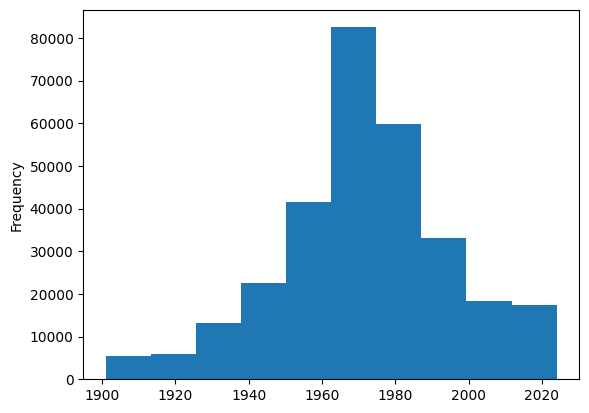

In [ ]:
# plot number of records per year
df_ent_us_recent.year.plot.hist()
# notice the collection bias for the 1960s-90s

### Fix Cnidaria butterflies

In [ ]:
# check if Cnidaria is still present
df_ent_us_recent[df_ent_us_recent.phylum == 'Cnidaria']

,gbifID,datasetKey,occurrenceID,kingdom,phylum,class,order,family,genus,species,...,collectionCode,catalogNumber,identifiedBy,dateIdentified,license,rightsHolder,recordedBy,lastInterpreted,mediaType,issue


In [ ]:
# check a different way, just in case
df_ent_us_recent.phylum.unique()

# looks like the subsets removed them, so no work needed here!

array(['Arthropoda', nan], dtype=object)

### Fix insects with nan phyla

In [ ]:
# check if this is still an issue
df_ent_us_recent[df_ent_us_recent.phylum.isnull()]
# still 200+ records with this issue

,gbifID,datasetKey,occurrenceID,kingdom,phylum,class,order,family,genus,species,...,collectionCode,catalogNumber,identifiedBy,dateIdentified,license,rightsHolder,recordedBy,lastInterpreted,mediaType,issue
1539,1039030291,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:07618e5d-319b-4109-9800-da0dccd2908b,Animalia,NaN,NaN,NaN,NaN,Caria,Caria ino,...,ENT,YPM ENT 756892,NaN,NaN,CC0_1_0,Yale Peabody Museum,John R. Heitzman,2025-04-01T13:31:37.201Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
2382,2283526148,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:0b5787d0-38e7-41c7-913d-8ef3d2fba135,Animalia,NaN,NaN,NaN,Scolytidae,NaN,NaN,...,ENT,YPM ENT 969752,NaN,NaN,CC0_1_0,Yale Peabody Museum,Raymond J. Pupedis,2025-04-01T13:31:38.364Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
3889,1039039049,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:12d18fbe-9e60-4973-bcaa-849e1e194cac,Animalia,NaN,NaN,NaN,NaN,Calephelis,Calephelis nemesis,...,ENT,YPM ENT 443283,NaN,NaN,CC0_1_0,Yale Peabody Museum,Roy O. Kendall,2025-04-01T13:31:37.956Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
5404,1039044014,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:1a65c7c2-09cb-4896-8d3c-6817ecc86079,Animalia,NaN,NaN,NaN,NaN,Calephelis,Calephelis borealis,...,ENT,YPM ENT 755959,NaN,NaN,CC0_1_0,Yale Peabody Museum,NaN,2025-04-01T13:31:42.566Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
5952,1831381367,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:1ceecf52-a9e0-4d38-b73d-6b25a80b3850,Animalia,NaN,NaN,NaN,NaN,Calephelis,Calephelis borealis,...,ENT,YPM ENT 934340,NaN,NaN,CC0_1_0,Yale Peabody Museum,"Thomas Breden, Dale F. Schweitzer",2025-04-01T13:31:43.162Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414145,1039179134,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:da5001e5-c52c-426a-b821-a2d51600f04f,Animalia,NaN,NaN,NaN,NaN,Calephelis,Calephelis virginiensis,...,ENT,YPM ENT 796568,NaN,NaN,CC0_1_0,Yale Peabody Museum,Victoria J. Mason,2025-04-01T13:32:12.125Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
415844,1039184750,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:e2662d81-c260-48ca-9054-79b79cb91e75,Animalia,NaN,NaN,NaN,NaN,Calephelis,Calephelis nemesis,...,ENT,YPM ENT 755041,NaN,NaN,CC0_1_0,Yale Peabody Museum,Roger L. Heitzman,2025-04-01T13:32:13.008Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
416421,4412912339,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:e4ff17e1-6b84-42ad-856a-eb5c0e24eaaf,Animalia,NaN,NaN,NaN,NaN,Calephelis,Calephelis borealis,...,ENT,YPM ENT 601117,NaN,NaN,CC0_1_0,Yale Peabody Museum,John W. Peacock,2025-04-01T13:32:13.168Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
417937,1039191601,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:ec3b0f72-c5c1-4982-9d0d-1e2288652875,Animalia,NaN,NaN,NaN,NaN,Calephelis,Calephelis virginiensis,...,ENT,YPM ENT 443262,NaN,NaN,CC0_1_0,Yale Peabody Museum,Dean F. Berry,2025-04-01T13:32:14.565Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...


In [ ]:
# find out which unique species/genera/families are represented here
df_ent_us_recent[df_ent_us_recent.phylum.isnull()].species.unique()

array(['Caria ino', nan, 'Calephelis nemesis', 'Calephelis borealis',
       'Calephelis virginiensis'], dtype=object)

In [ ]:
df_ent_us_recent[df_ent_us_recent.phylum.isnull()].genus.unique()

array(['Caria', nan, 'Calephelis', 'Brachybothrium'], dtype=object)

In [ ]:
# check families
df_ent_us_recent[df_ent_us_recent.phylum.isnull()].family.unique()
# none

array([nan, 'Scolytidae'], dtype=object)

In [ ]:
# check orders
df_ent_us_recent[df_ent_us_recent.phylum.isnull()].order.unique()
# none

array([nan], dtype=object)

Will need to add in genus, family, order, class, phylum for the unmatched taxa
* species: 'Caria ino', 'Calephelis nemesis', 'Calephelis borealis', 'Calephelis virginiensis'
* genus: 'Caria', 'Calephelis', 'Brachybothrium'
* family: 'Scolytidae'

It may be that all genera are present if species is present, so fix genus and family then check if any species were left behind.

We will pull the correct taxonomy from GBIF or Wikipedia

At the end, check if there any NA rows remaining

In [ ]:
# Is the taxonomy correct for other instances of these taxa?
df_ent_us_recent[df_ent_us_recent.family == 'Scolytidae'].order.unique()
# nope

array([nan], dtype=object)

In [ ]:
# start with family, since there's only one to fix
# Arthropoda - Insecta - Coleoptera - Scolytidae
df_ent_us_recent.loc[df_ent_us_recent.family == 'Scolytidae', ['phylum', 'class', 'order']] = 'Arthropoda', 'Insecta', 'Coleoptera'

df_ent_us_recent[df_ent_us_recent.family == 'Scolytidae'].head() # check

,gbifID,datasetKey,occurrenceID,kingdom,phylum,class,order,family,genus,species,...,collectionCode,catalogNumber,identifiedBy,dateIdentified,license,rightsHolder,recordedBy,lastInterpreted,mediaType,issue
2382,2283526148,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:0b5787d0-38e7-41c7-913d-8ef3d2fba135,Animalia,Arthropoda,Insecta,Coleoptera,Scolytidae,NaN,NaN,...,ENT,YPM ENT 969752,NaN,NaN,CC0_1_0,Yale Peabody Museum,Raymond J. Pupedis,2025-04-01T13:31:38.364Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
10895,2283526464,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:3478f083-b1cc-45ea-b2d3-28279b960c04,Animalia,Arthropoda,Insecta,Coleoptera,Scolytidae,NaN,NaN,...,ENT,YPM ENT 969497,NaN,NaN,CC0_1_0,Yale Peabody Museum,Raymond J. Pupedis,2025-04-01T13:31:47.719Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
30768,2283527095,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:95c4f470-6378-4b8a-8c3a-3a0640c696f8,Animalia,Arthropoda,Insecta,Coleoptera,Scolytidae,NaN,NaN,...,ENT,YPM ENT 969506,NaN,NaN,CC0_1_0,Yale Peabody Museum,Raymond J. Pupedis,2025-04-01T13:32:04.302Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
34638,2283530209,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:a8730d63-5e34-4854-8a0d-a0345cd06d30,Animalia,Arthropoda,Insecta,Coleoptera,Scolytidae,NaN,NaN,...,ENT,YPM ENT 969504,NaN,NaN,CC0_1_0,Yale Peabody Museum,Raymond J. Pupedis,2025-04-01T13:32:05.934Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
41036,2283532388,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:c79a31fd-ed6f-42bf-8ec5-b75bd73529e1,Animalia,Arthropoda,Insecta,Coleoptera,Scolytidae,NaN,NaN,...,ENT,YPM ENT 969503,NaN,NaN,CC0_1_0,Yale Peabody Museum,Raymond J. Pupedis,2025-04-01T13:32:10.215Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...


Calephelis - Riodinidae - Lepidoptera - Insecta - Arthropoda

Caria - Riodinidae - Lepidoptera - Insecta - Arthropoda

Brachybothrium - Antrodiaetidae - Arachnida - Chelicerata - Arthropoda
* however, there are only 2 records on all of GBIF (not just YPM), so it is likely an unused synonym
* removing this record since it is uncertain

In [ ]:
# is the taxonomy correct in other instances of the genera?
df_ent_us_recent[df_ent_us_recent.genus.isin(['Caria', 'Calephelis', 'Brachybothrium'])].order.unique()
# nope

array([nan], dtype=object)

In [ ]:
# apply correction the same as above
df_ent_us_recent.loc[df_ent_us_recent.genus.isin(['Caria', 'Calephelis']), ['phylum', 'class', 'order', 'family']] = 'Arthropoda', 'Insecta', 'Lepidoptera', 'Riodinidae'

df_ent_us_recent[df_ent_us_recent.genus.isin(['Caria', 'Calephelis'])].head() # check

,gbifID,datasetKey,occurrenceID,kingdom,phylum,class,order,family,genus,species,...,collectionCode,catalogNumber,identifiedBy,dateIdentified,license,rightsHolder,recordedBy,lastInterpreted,mediaType,issue
1539,1039030291,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:07618e5d-319b-4109-9800-da0dccd2908b,Animalia,Arthropoda,Insecta,Lepidoptera,Riodinidae,Caria,Caria ino,...,ENT,YPM ENT 756892,NaN,NaN,CC0_1_0,Yale Peabody Museum,John R. Heitzman,2025-04-01T13:31:37.201Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
3889,1039039049,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:12d18fbe-9e60-4973-bcaa-849e1e194cac,Animalia,Arthropoda,Insecta,Lepidoptera,Riodinidae,Calephelis,Calephelis nemesis,...,ENT,YPM ENT 443283,NaN,NaN,CC0_1_0,Yale Peabody Museum,Roy O. Kendall,2025-04-01T13:31:37.956Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
5404,1039044014,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:1a65c7c2-09cb-4896-8d3c-6817ecc86079,Animalia,Arthropoda,Insecta,Lepidoptera,Riodinidae,Calephelis,Calephelis borealis,...,ENT,YPM ENT 755959,NaN,NaN,CC0_1_0,Yale Peabody Museum,NaN,2025-04-01T13:31:42.566Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
5952,1831381367,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:1ceecf52-a9e0-4d38-b73d-6b25a80b3850,Animalia,Arthropoda,Insecta,Lepidoptera,Riodinidae,Calephelis,Calephelis borealis,...,ENT,YPM ENT 934340,NaN,NaN,CC0_1_0,Yale Peabody Museum,"Thomas Breden, Dale F. Schweitzer",2025-04-01T13:31:43.162Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
6660,1831381283,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:206034a8-85e1-441b-bb08-38bcad8b3383,Animalia,Arthropoda,Insecta,Lepidoptera,Riodinidae,Calephelis,Calephelis borealis,...,ENT,YPM ENT 934338,NaN,NaN,CC0_1_0,Yale Peabody Museum,"Thomas Breden, Dale F. Schweitzer",2025-04-01T13:31:43.820Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...


In [ ]:
# remove record with Brachybothrium
df_ent_us_recent = df_ent_us_recent[df_ent_us_recent.genus != 'Brachybothrium']

df_ent_us_recent[df_ent_us_recent.genus == 'Brachybothrium']

,gbifID,datasetKey,occurrenceID,kingdom,phylum,class,order,family,genus,species,...,collectionCode,catalogNumber,identifiedBy,dateIdentified,license,rightsHolder,recordedBy,lastInterpreted,mediaType,issue


In [ ]:
# check that fixing genera also fixed species
df_ent_us_recent[df_ent_us_recent.phylum.isnull()].species.unique() # looks good

array([], dtype=object)

### Fix year type

In [ ]:
# year has a decimal place, fix that
df_ent_us_recent.year = df_ent_us_recent.year.astype('int')

print(df_ent_us_recent.year.dtype)
df_ent_us_recent.year.head(2)

int64


,year
0,1966
1,1978


## Save dataset

In [ ]:
# saved cleaned table
df_ent_us_recent.to_csv('ypm_ent_usa_post1900_cleaned_20250408.csv', index=False)

# Calculate summary table

## Create summary table
Goal: make a table with a column for:
*   year
*   state
*   total number of species
*   total abundance (number of occurrences)
*   Lepidoptera n species
*   Lepidoptera abundance
*   Hymenoptera n species and abundance
*   Diptera n species and abundance
*   Coleoptera n species and abundance
*   Odonata n species and abundance
*   Nymphalidae n species and abundance

Note that inferring abundance from museum records is quite biased - would not normally do this without applying some mathematical corrections, but for now are leaving as is for the purposes of exploring. We will likely only analyze number of species, not number of occurrences (abundance).



In [3]:
# read in cleaned table if needed
ypm_ent = pd.read_csv('ypm_ent_usa_post1900_cleaned_20250408.csv') # uploaded this to my runtime files temporarily, too big to load to github

ypm_ent.head()

,gbifID,datasetKey,occurrenceID,kingdom,phylum,class,order,family,genus,species,...,collectionCode,catalogNumber,identifiedBy,dateIdentified,license,rightsHolder,recordedBy,lastInterpreted,mediaType,issue
0,3913895301,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:00006775-753e-4ed0-bbe6-0702cae6c26b,Animalia,Arthropoda,Insecta,Lepidoptera,Papilionidae,Papilio,Papilio polyxenes,...,ENT,YPM ENT 592844,NaN,NaN,CC0_1_0,Yale Peabody Museum,R. T. Cail,2025-04-01T13:31:34.353Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
1,1438048515,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:000426c2-4fff-44bf-97c3-461d8022c177,Animalia,Arthropoda,Insecta,Lepidoptera,Noctuidae,Achatia,Achatia evicta,...,ENT,YPM ENT 882660,NaN,NaN,CC0_1_0,Yale Peabody Museum,Richard E. Gray,2025-04-01T13:31:34.410Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
2,1838432720,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:00091984-cf96-4498-a6c6-e034f72a355a,Animalia,Arthropoda,Insecta,Lepidoptera,Geometridae,Lobophora,Lobophora nivigerata,...,ENT,YPM ENT 941874,NaN,NaN,CC0_1_0,Yale Peabody Museum,David S. MacDonald,2025-04-01T13:31:25.822Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
3,1935872503,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:0009a4ea-0d53-46da-bf70-949145977b1b,Animalia,Arthropoda,Insecta,Lepidoptera,Geometridae,Metarranthis,Metarranthis amyrisaria,...,ENT,YPM ENT 956749,NaN,NaN,CC0_1_0,Yale Peabody Museum,"Timothy L. McCabe, Dale F. Schweitzer",2025-04-01T13:31:34.328Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...
4,2565549387,96404cc2-f762-11e1-a439-00145eb45e9a,urn:uuid:000a73bd-10b3-46d3-b38c-be8c3d909b83,Animalia,Arthropoda,Insecta,Lepidoptera,Crambidae,Parapoynx,Parapoynx obscuralis,...,ENT,YPM ENT 986749,NaN,NaN,CC0_1_0,Yale Peabody Museum,Herman P. Wilhelm,2025-04-01T13:31:34.426Z,NaN,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...


In [4]:
ypm_ent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300109 entries, 0 to 300108
Data columns (total 44 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   gbifID                            300109 non-null  int64  
 1   datasetKey                        300109 non-null  object 
 2   occurrenceID                      300109 non-null  object 
 3   kingdom                           300109 non-null  object 
 4   phylum                            300109 non-null  object 
 5   class                             300109 non-null  object 
 6   order                             300091 non-null  object 
 7   family                            299864 non-null  object 
 8   genus                             297026 non-null  object 
 9   species                           284483 non-null  object 
 10  infraspecificEpithet              3328 non-null    object 
 11  taxonRank                         300109 non-null  o

In [16]:
# aggregate and calculate cols for total n species and abundance
ent_totals = ypm_ent.groupby(['year', 'stateProvince']).agg(total_n_species = ('verbatimScientificName', 'nunique'),
                                               total_abundance = ('verbatimScientificName', 'count')).reset_index()
ent_totals.tail()

,year,stateProvince,total_n_species,total_abundance
4170,2024.0,Florida,29,56
4171,2024.0,Maine,3,3
4172,2024.0,Maryland,2,3
4173,2024.0,New Hampshire,40,121
4174,2024.0,Virginia,3,10


<Axes: xlabel='year'>

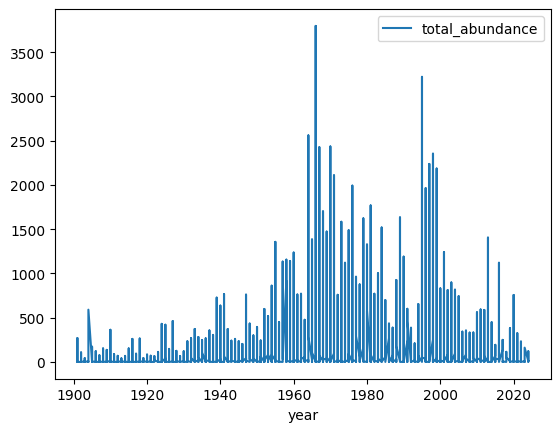

In [9]:
# plot occurrences per year
ent_totals.plot(x='year', y='total_abundance')

<Axes: xlabel='year'>

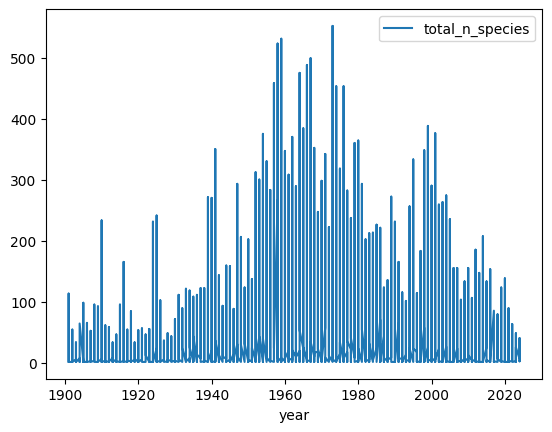

In [8]:
# plot n unique species per year
ent_totals.plot(x='year', y='total_n_species')
# not quite as biased as abundance, but still biased

In [13]:
# calculate cols for lepidoptera n species and abundance - test before loop
ent_lepid = ypm_ent[ypm_ent.order == 'Lepidoptera'].groupby(['year', 'stateProvince']).agg(lepidoptera_n_species = ('verbatimScientificName', 'nunique'),
                                               lepidoptera_abundance = ('verbatimScientificName', 'count')).reset_index()
ent_lepid.tail()

,year,stateProvince,lepidoptera_n_species,lepidoptera_abundance
3867,2024.0,Connecticut,5,11
3868,2024.0,Florida,29,56
3869,2024.0,Maine,3,3
3870,2024.0,New Hampshire,40,121
3871,2024.0,Virginia,3,10


In [17]:
# do this as a loop!

orders = ypm_ent.order.unique()

for i in orders:
  print(i)
  df_tmp = ypm_ent[ypm_ent.order == i].groupby(['year', 'stateProvince']).agg(
    n_species = ('verbatimScientificName', 'nunique'),
    abundance = ('verbatimScientificName', 'count')
    ).reset_index()
  df_tmp = df_tmp.rename(columns = {'n_species': f'{i}_n_species', 'abundance': f'{i}_abundance'})
  ent_totals = ent_totals.merge(df_tmp, how='outer', on=['year','stateProvince'])

ent_totals.tail()

Lepidoptera
Hymenoptera
Coleoptera
Diptera
Odonata
Ixodida
Megaloptera
Hemiptera
Orthoptera
Trichoptera
Trombidiformes
Neuroptera
Psocodea
Mesostigmata
Siphonaptera
Mecoptera
nan
Sarcoptiformes
Araneae
Thysanoptera
Entomobryomorpha
Raphidioptera
Mantodea
Scolopendromorpha
Ephemeroptera
Scorpiones
Solifugae
Dermaptera
Spirobolida
Pseudoscorpiones
Poduromorpha


,year,stateProvince,total_n_species,total_abundance,Lepidoptera_n_species,Lepidoptera_abundance,Hymenoptera_n_species,Hymenoptera_abundance,Coleoptera_n_species,Coleoptera_abundance,...,Solifugae_n_species,Solifugae_abundance,Dermaptera_n_species,Dermaptera_abundance,Spirobolida_n_species,Spirobolida_abundance,Pseudoscorpiones_n_species,Pseudoscorpiones_abundance,Poduromorpha_n_species,Poduromorpha_abundance
4170,2024.0,Florida,29,56,29.0,56.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4171,2024.0,Maine,3,3,3.0,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4172,2024.0,Maryland,2,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4173,2024.0,New Hampshire,40,121,40.0,121.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4174,2024.0,Virginia,3,10,3.0,10.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# now do it for the families of interest

families = ['Nymphalidae', 'Apidae', 'Noctuidae', 'Papilionidae'] # some common, some important

for i in families:
  print(i)
  df_tmp = ypm_ent[ypm_ent.family == i].groupby(['year', 'stateProvince']).agg(
    n_species = ('verbatimScientificName', 'nunique'),
    abundance = ('verbatimScientificName', 'count')
    ).reset_index()
  df_tmp = df_tmp.rename(columns = {'n_species': f'{i}_n_species', 'abundance': f'{i}_abundance'})
  ent_totals = ent_totals.merge(df_tmp, how='outer', on=['year','stateProvince'])

ent_totals.tail()

Nymphalidae
Apidae
Noctuidae
Papilionidae


,year,stateProvince,total_n_species,total_abundance,Lepidoptera_n_species,Lepidoptera_abundance,Hymenoptera_n_species,Hymenoptera_abundance,Coleoptera_n_species,Coleoptera_abundance,...,Poduromorpha_n_species,Poduromorpha_abundance,Nymphalidae_n_species,Nymphalidae_abundance,Apidae_n_species,Apidae_abundance,Noctuidae_n_species,Noctuidae_abundance,Papilionidae_n_species,Papilionidae_abundance
4170,2024.0,Florida,29,56,29.0,56.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4171,2024.0,Maine,3,3,3.0,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4172,2024.0,Maryland,2,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4173,2024.0,New Hampshire,40,121,40.0,121.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4174,2024.0,Virginia,3,10,3.0,10.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Save dataset

In [19]:
# save this version
ent_totals.to_csv('ypm_ent_taxo_summaries_20250424.csv', index=False)